# 目標
- Lorenz96離散システムにおける、二次変分によるパラメータと状態変数の信頼区間推定の完成
- ヒル式システムにおける双子実験 ← ここまで
- 黒田研実データへの適用
- システムノイズ(なし/あり)固定区間スムーザーの実装

## Lorenz96離散システムにおける、二次変分によるパラメータと状態変数の信頼区間推定

T 1.0
day 5.0


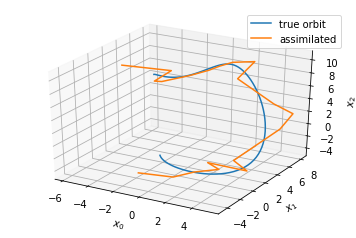

Before assimilation
cost 2162.46403807


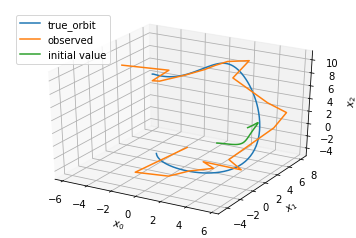

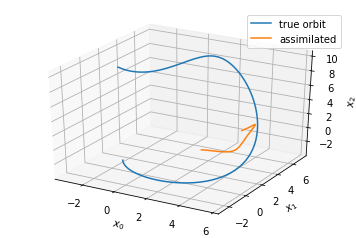

Analytical and numerical gradient comparison
gr_anal [  9.50702461e+00  -1.67243026e+02  -2.76102060e+02  -9.56868619e+00
   1.00003573e+02   5.72696958e+00   8.79387143e+01  -4.76862309e+01
  -3.14484064e+03  -8.50452224e+00  -1.08172032e+01  -3.90861103e+00
   5.88657398e+01   2.84638885e+01  -5.05945238e+01  -4.53230576e+01
   3.42237306e+00   2.62860510e+00   2.81809033e+00   2.96681218e+00
  -1.95875178e-01   3.73501144e+00  -5.09610098e+00]
gr_num [  9.50854686e+00  -1.67218945e+02  -2.76089328e+02  -9.56027797e+00
   1.00007876e+02   5.72903064e+00   8.79495181e+01  -4.76798371e+01
  -3.14596495e+03  -8.47610403e+00  -1.07890102e+01  -3.87727215e+00
   5.88949058e+01   2.84922578e+01  -5.05620888e+01  -4.52938533e+01
   3.44787306e+00   2.65410510e+00   2.84359033e+00   2.99231218e+00
  -1.70375178e-01   3.76051144e+00  -5.07060098e+00]
relative error [ -1.60093222e-04   1.44009801e-04   4.61139418e-05   8.79495413e-04
  -4.30174937e-05  -3.59756223e-04  -1.22840932e-04   1.3409

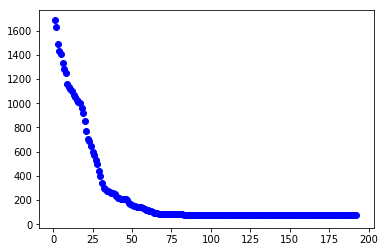

true x0 [-3.115768  2.942545  7.7938    3.22996   4.079255  6.517455 -0.908981]


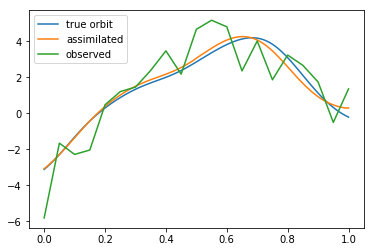

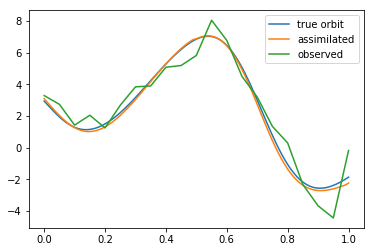

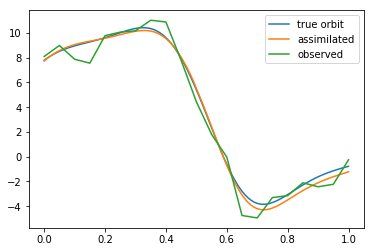

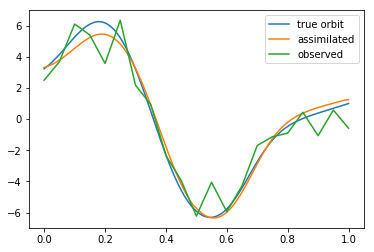

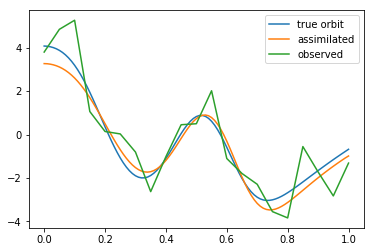

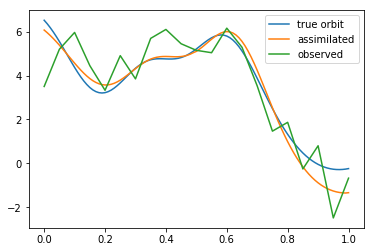

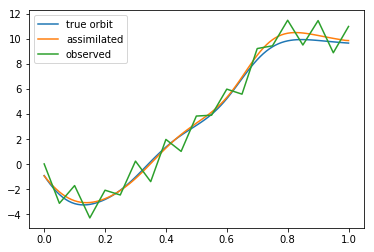

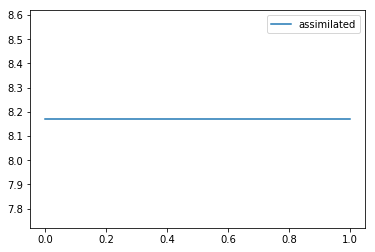

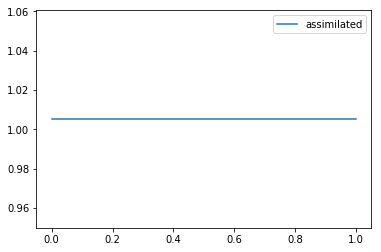

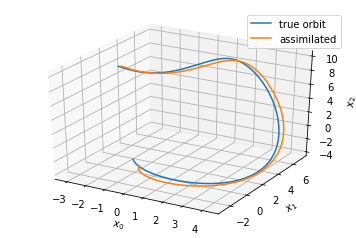

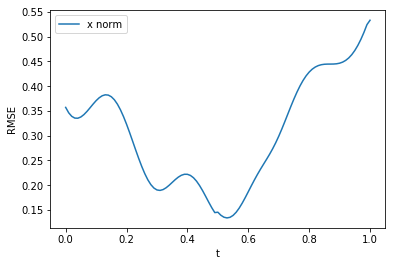

RMSE:  0.168090949303
hessian [[  5.17121663e+02   2.61454904e+02  -9.64462549e+01  -1.85815417e+02
   -2.14833998e+02   1.14668184e+02  -1.19676524e+02   7.96012453e+01
   -1.39038490e+03]
 [  2.61454904e+02   1.54533757e+02  -5.70116923e+01  -9.38506249e+01
   -1.09984000e+02   2.10776225e+01  -3.86297216e+01   2.10339720e+01
   -1.15258510e+03]
 [ -9.64462549e+01  -5.70116923e+01   5.03806528e+01   5.52585905e+01
    4.91232335e+01   1.46554110e+00   1.21724185e+01   4.99005634e+00
    8.25134455e+02]
 [ -1.85815417e+02  -9.38506249e+01   5.52585905e+01   9.31172131e+01
    8.60603822e+01  -5.60321037e+01   5.26318062e+01  -2.60417800e+01
    6.73341199e+02]
 [ -2.14833998e+02  -1.09984000e+02   4.91232335e+01   8.60603822e+01
    1.23590523e+02  -2.68406328e+01   3.71961928e+01  -3.34790050e+01
    9.47642713e+02]
 [  1.14668184e+02   2.10776225e+01   1.46554110e+00  -5.60321037e+01
   -2.68406328e+01   1.67753983e+02  -1.02299092e+02   6.86784916e+01
    1.08830700e+03]
 [ -1.1967

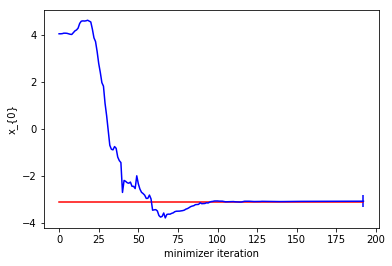

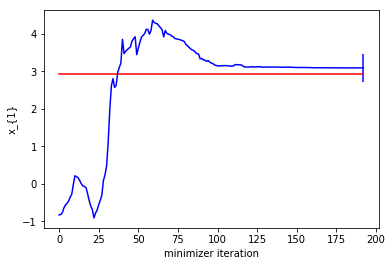

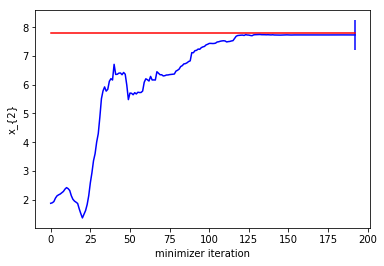

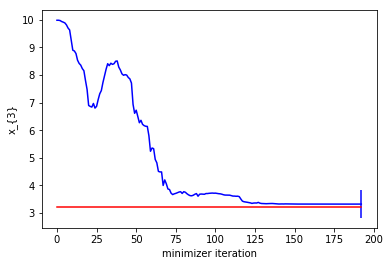

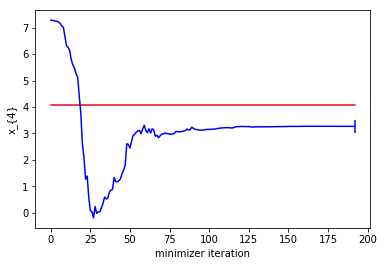

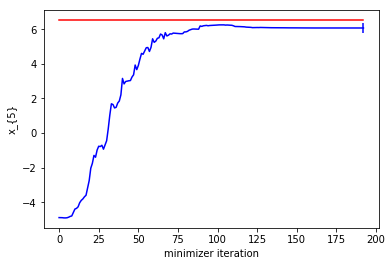

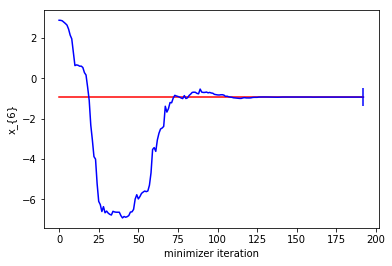

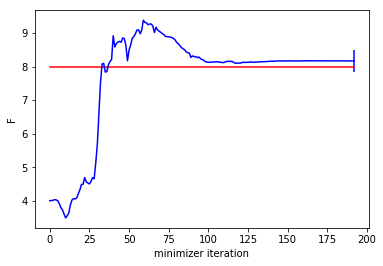

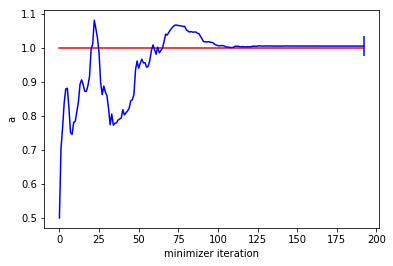

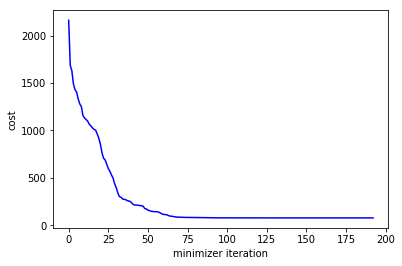

4DVar optimal cost:  76.8930164932
true cost:  78.1504356868


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, dt):
        self.N = N
        self.M = 2
        self.dt = dt
        self.m = np.zeros((self.N + self.M, self.N + self.M))
        self.mm = np.zeros((self.N + self.M, self.N + self.M, self.N + self.M))
            
    def gradient(self, x, x_next):
        x_next[0] =        (x[self.N + 1] * (x[1]   - x[self.N-2]) * x[self.N-1] + x[self.N]) * self.dt + x[0]        * (1. - self.dt)
        x_next[1] =        (x[self.N + 1] * (x[2]   - x[self.N-1]) * x[0]        + x[self.N]) * self.dt + x[1]        * (1. - self.dt)
        for i in range(2, self.N-1):
            x_next[i] =    (x[self.N + 1] * (x[i+1] - x[i-2])      * x[i-1]      + x[self.N]) * self.dt + x[i]        * (1. - self.dt)
        x_next[self.N-1] = (x[self.N + 1] * (x[0]   - x[self.N-3]) * x[self.N-2] + x[self.N]) * self.dt + x[self.N-1] * (1. - self.dt)
        
        x_next[self.N] = x[self.N]
        x_next[self.N+1] = x[self.N+1]
        return x_next
    
#    def tl(self, x):
#        for i in range(self.N):
#            for j in range(self.N + self.M):
#                self.m[i,j] = self.dt * (
#                              x[self.N + 1] * ((((i+1) % self.N) == j) - (((i-2) % self.N) == j)) * x[(i-1) % self.N]\
#                            + x[self.N + 1] * (x[(i+1) % self.N]       - x[(i-2) % self.N])       * (((i-1) % self.N) == j)\
#                            + (N+1 == j)    * (x[(i+1) % self.N]       - x[(i-2) % self.N])       * x[(i-1) % self.N]\
#                            + (N   == j)\
#                            )\
#                            + (1. - self.dt) * (i == j)
#        return self.m
#
#    def gradient_adjoint(self, la, x):
#        return self.tl(x).transpose() @ la
    
    def gradient_adjoint(self, la, x):
        # fastest code
        d = np.zeros(self.N + self.M)
        for j in range(self.N):
            d[j] = self.dt * x[self.N+1] * (x[(j-2) % self.N] * la[(j-1) % self.N] - x[(j+1) % self.N] * la[(j+2) % self.N] + (x[(j+2) % self.N] - x[(j-1) % self.N]) * la[(j+1) % self.N])\
                 + (1. - self.dt) * la[j]
        d[self.N] = self.dt * sum(la[:self.N]) + la[self.N] # fixed
        for i in range(self.N):
            d[self.N+1] += self.dt * (x[(i+1) % self.N] - x[(i-2) % self.N]) * x[(i-1) % self.N] * la[i]
        d[self.N+1] += la[self.N+1] # fixed
        return d
    
    def gradient_neighboring(self, xi, x):
        d = np.zeros(self.N + self.M)
        for i in range(self.N):
            d[i] = self.dt * (xi[self.N+1] * (x[(i+1) % self.N] - x[(i-2) % self.N]) * x[(i-1) % self.N] + x[self.N+1] * (xi[(i+1) % self.N] - xi[(i-2) % self.N]) * x[(i-1) % self.N] + x[self.N+1] * (x[(i+1) % self.N] - x[(i-2) % self.N]) * xi[(i-1) % self.N] + xi[self.N]) + (1. - self.dt) * xi[i]
        d[self.N] = xi[self.N]
        d[self.N+1] = xi[self.N+1]
        return d
    
#    def gradient_secondadj(self, nu, x, la, xi): # fix me!
#        # fastest code
#        d = np.zeros(self.N + self.M)
#        for i in range(self.N):
#            d[i] = self.dt * x[self.N+1] * (x[(j-2) % self.N] * nu[(j-1) % self.N] - x[(j+1) % self.N] * nu[(j+2) % self.N] + (x[(j+2) % self.N] - x[(j-1) % self.N]) * nu[(j+1) % self.N])\
#                 + (1. - self.dt) * nu[j]\
#                 + self.dt * (   (xi[self.N+1] * x[(j-2) % self.N] + x[self.N+1] * xi[(j-2) % self.N]) * la[(j-1) % self.N]\
#                               - (xi[self.N+1] * x[(j+1) % self.N] + x[self.N+1] * xi[(j+1) % self.N]) * la[(j+2) % self.N]\
#                               + la[(j+1) % self.N] * ( xi[self.N+1] * ( x[(j+2) % self.N] -  x[(j-1) % self.N])\
#                               + x[self.N+1] * (xi[(j+2) % self.N] - xi[(j-1) % self.N]) ) )
#        d[self.N]   = self.dt * sum(nu[:self.N]) + nu[self.N] # fixed
#        for i in range(self.N):
#            d[self.N+1] += self.dt * (x[(i+1) % self.N] - x[(i-2) % self.N]) * x[(i-1) % self.N] * nu[i]\
#                         + self.dt * (  (xi[(i+1) % self.N] - xi[(i-2) % self.N]) *  x[(i-1) % self.N]\
#                                      + ( x[(i+1) % self.N] -  x[(i-2) % self.N]) * xi[(i-1) % self.N]\
#                                     ) * la[i]
#        d[self.N+1] += nu[self.N+1] # fixed
#        return d

    def tl_hessian(self, x):
        m = np.zeros((self.N + self.M, self.N + self.M, self.N + self.M))
        for i in range(self.N):
            for k in range(self.N):
                for j in range(self.N):
                    m[i,j,k] =   ((self.N+1)==j) * ((((i+1)%self.N)==k) - (((i-2)%self.N)==k)) * x[(i-1)%self.N]\
                               + ((self.N+1)==j) * (x[(i+1)%self.N]     - x[(i-2)%self.N])     * (((i-1)%self.N)==k)\
                               + ((self.N+1)==k) * ((((i+1)%self.N)==j) - (((i-2)%self.N)==j)) * x[(i-1)%self.N]\
                               + x[self.N+1]     * ((((i+1)%self.N)==j) - (((i-2)%self.N)==j)) * (((i-1)%self.N)==k)\
                               + ((self.N+1)==k) * (x[(i+1)%self.N]     - x[(i-2)%self.N])     * (((i-1)%self.N)==j)\
                               + x[self.N+1]     * ((((i+1)%self.N)==k) - (((i-2)%self.N)==k)) * (((i-1)%self.N)==j)
        return self.dt * m
    
    def gradient_secondadj(self, nu, x, la, xi):
        return self.gradient_adjoint(nu, x) + (self.tl_hessian(x) @ xi).transpose() @ la
        
        
class Adjoint:
    def __init__(self, dx, dla, dxi, dnu, N, M, T, dt, it, sysnoise_it, obs_variance, sysnoise_variance, x, y, la, xi, nu, q):
        self.dx = dx
        self.dla = dla
        self.dxi = dxi
        self.dnu = dnu
        self.N = N
        self.M = M
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.la = la
        self.xi = xi
        self.nu = nu
        self.q = q
        self.it = it
        self.sysnoise_it = sysnoise_it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.sysnoise_steps = int(self.minute_steps/sysnoise_it)
        self.obs_variance = obs_variance
        self.sysnoise_variance = sysnoise_variance
        self.gr = np.zeros((self.sysnoise_steps + 1) * N + M)
        
    def orbit(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                handler(self.dx, self.x[n], self.x[n+1])
            self.x[self.sysnoise_it*(i+1), :self.N] += self.q[i]
        return self.x
    
    def neighboring(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                self.xi[n+1] = handler(self.dxi, self.xi[n], self.x[n])
#            self.xi[self.sysnoise_it*(i+1), :self.N] += self.dq[i] # no sysnoise variational to obtain hessian wrt initial state and parameters
        return self.xi
    
    def observed(self, stddev):
        self.orbit()
        self.x[:self.N] += stddev * np.random.randn(self.steps, self.N)
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        self.x[:self.N] += stddev * np.random.randn(self.steps, self.N)
        return tob, self.x
    
    def gradient(self):
        self.la[self.minute_steps, :self.N] = (self.x[self.minute_steps, :self.N] - self.y[self.steps])/self.obs_variance
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                self.la[n] = handler(self.dla, self.la[n+1], self.x[n]) # x should be current one.
            self.la[self.it*i, :self.N] += (self.x[self.it*i, :self.N] - self.y[i])/self.obs_variance
        return self.la[0]

    def gradient_from_x0(self, x0_q):
        self.x[0] = np.copy(x0_q[:self.N + self.M])
        for i in range(self.sysnoise_steps):
            self.q[i] = x0_q[self.N*(i+1) + self.M: self.N*(i+2) + self.M]
        self.orbit()
        self.la.fill(0.)
        self.gr.fill(0.)
        self.gradient()
        self.gr[:self.N + self.M] = self.la[0]
        for i in range(self.sysnoise_steps):
            self.gr[self.N*(i+1) + self.M: self.N*(i+2) + self.M] = la[self.sysnoise_it*(i+1), :self.N] + self.q[i]/self.sysnoise_variance # Gamma la[self.sysnoise_it*(i+1)] = la[self.sysnoise_it*(i+1),:self.N]
#            self.gr[self.N*(i+1) + self.M: self.N*(i+2) + self.M] = 0
        return self.gr

    def hessian_vector_product(self, xi0):
        self.xi[0] = np.copy(xi0)
        self.neighboring()
        self.nu.fill(0.)
        self.nu[self.minute_steps, :self.N] = self.xi[self.minute_steps, :self.N]/self.obs_variance # fixed
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                self.nu[n] = handler(self.dnu, self.nu[n+1], self.x[n], self.la[n+1], self.xi[n]) # x and xi should be current one.
            self.nu[self.it*i, :self.N] += self.xi[self.it*i, :self.N]/self.obs_variance
        return self.nu[0]
    
    def cost(self, x0_q):
        self.x[0] = np.copy(x0_q[:self.N + self.M])
        for i in range(self.sysnoise_steps):
            self.q[i] = x0_q[self.N*(i+1) + self.M : self.N*(i+2) + self.M]
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i, :self.N] - self.y[i]) @ (self.x[self.it*i, :self.N] - self.y[i])/self.obs_variance
        for i in range(self.sysnoise_steps):
            cost += self.q[i] @ self.q[i] / self.sysnoise_variance
        return cost/2.0 # fixed
    
    def true_cost(self, tob):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
            cost += (tob[self.it*i] - self.y[i]) @ (tob[self.it*i] - self.y[i])
        return cost/self.obs_variance/2.0 # fixed
    
    def numerical_gradient_from_x0(self, x0_q, h):
        gr = np.zeros(self.N * (self.sysnoise_steps+1) + self.M)
        c1 = self.cost(x0_q)
        for j in range(self.N * (self.sysnoise_steps+1) + self.M):
            xx = np.copy(x0_q)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h        
        return gr
    
    def numerical_hessian_from_x0(self, x0_q, h):
        hess = np.zeros((self.N + self.M, self.N + self.M))
        gr1 = np.copy(self.gradient_from_x0(x0_q))
#        print("gr1", gr1)
        for i in range(self.N + self.M):
            for j in range(self.N + self.M):
                xx = np.copy(x0_q)
                xx[j] += h
                gr2 = np.copy(self.gradient_from_x0(xx))
#                print("gr2", gr2)
#                print("(gr2 - gr1)", (gr2 - gr1))
                hess[j,i] = (gr2[i] - gr1[i])/h
#                print("")
#            print("")
        return hess
    
    def numerical_hessian_from_x0_2(self, x0_q, h):
        hess = np.zeros((self.N + self.M, self.N + self.M))
        gr1 = np.copy(self.numerical_gradient_from_x0(x0_q, h))
        for i in range(self.N + self.M):
            for j in range(self.N + self.M):
                xx = np.copy(x0_q)
                xx[j] += h
                gr2 = np.copy(self.numerical_gradient_from_x0(xx, h))
                hess[j,i] = (gr2[i] - gr1[i])/h
        return hess

    def cbf(self, x0):
        global count, f_trace, a_trace, cost_trace, trace
        count += 1
        cos = self.cost(x0)
        plt.scatter(count, self.cost(x0), c='b')
        f_trace.append(x0[self.N])
        a_trace.append(x0[self.N+1])
        cost_trace.append(cos)
        for i in range(self.N):
            trace[i].append(x0[i])
    
#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
M = 2
F = 8

#pref = "data/" + str(N) + "/"
#pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_sysnoise_data/" + str(N) + "/"
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_discrete_data/" + str(N) + "/"
#pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_discrete_sysnoise_data/" + str(N) + "/"
#pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_discrete_sysnoise_data/params" + str(N) + "/F" + str(F) + "/"

year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 1.0
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1.

sysnoise_variance = 0.02
sysnoise_it = 50

sysnoise_steps = int(minute_steps/sysnoise_it)

lorenz = Lorenz96(N, dt)

tob = np.loadtxt(pref + "year.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)
t_plus_1 = np.arange(0., T+dt, dt)
t_it = np.arange(0., T, dt*it)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

x_opt_q = np.zeros((sysnoise_steps + 1) * N + M)
#x_opt_q[:N] = np.copy(tob[0]) + 0.001 * np.random.randn(N)
x_opt_q[:N] = np.loadtxt(pref + "assimilation_xzero.2.dat")
#x_opt_q[:N] = np.copy(obs[0])
x_opt_q[N] = 4.
x_opt_q[N+1] = 0.5

x  = np.zeros((minute_steps+1, N + M))
la = np.zeros((minute_steps+1, N + M))
xi = np.zeros((minute_steps+1, N + M))
nu = np.zeros((minute_steps+1, N + M))
q  = np.zeros((sysnoise_steps ,N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, lorenz.gradient_neighboring, lorenz.gradient_secondadj, N, M, T, dt, it, sysnoise_it, stddev, sysnoise_variance, x, obs, la, xi, nu, q)

print("Before assimilation")
print("cost", scheme.cost(x_opt_q))
compare_orbit3(tob[0:minute_steps+1], obs[0:steps+1], scheme.x, 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps+1], scheme.x)

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt_q)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt_q, 0.001)
print ("gr_num", gr_num)
print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
fig = plt.figure()
count = 0
f_trace = [x_opt_q[N]]
a_trace = [x_opt_q[N+1]]
cost_trace = [scheme.cost(x_opt_q)]
trace=[]
for i in range(N):
    trace.append([x_opt_q[i]])

#bnds = tuple([(-8., 24.) for i in range(N * (sysnoise_steps + 1))])
res = minimize(scheme.cost, x_opt_q, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
#res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
plt.show()
#print (res)
print ("true x0", tob[0])
estimated_x0 = np.copy(res.x)

for j in range(N):
    fig = plt.figure()
    plt.plot(t_plus_1, tob[0:minute_steps+1,j], label='true orbit')
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.plot(t_it_plus_1, obs[0:steps+1,j], label='observed')
    plt.legend()
    plt.show()

for j in range(N,N+M):
    fig = plt.figure()
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.legend()
    plt.show()


compare_orbit(tob[0:minute_steps+1], scheme.x[:,0:N])

#%%
fig = plt.figure()
plt.plot(t_plus_1, [np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(len(t_plus_1))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(int(len(t_plus_1)*0.4),int(len(t_plus_1)*0.6))]))


#%%
hessian_T = np.zeros((N + M, N + M))
xi0 = np.zeros(N + M)
for i in range(N + M):
    xi0.fill(0.)
    xi0[i] = 1.
    hessian_T[i] = np.copy(scheme.hessian_vector_product(xi0))

hessian = hessian_T.transpose()
hessian_inv = np.linalg.inv(hessian)
print("hessian", hessian)
#print("hessian_inverse", hessian_inv)
variance = np.diag(hessian_inv)
#print("variance", variance)
std_deviation = np.array([math.sqrt(variance[i]) for i in range(N+M)])

hess_num = scheme.numerical_hessian_from_x0(estimated_x0, 0.001)
print ("hessian_num", hess_num)

#hess_num2 = scheme.numerical_hessian_from_x0_2(estimated_x0, 0.001)
#print ("hessian_num2", hess_num2)


rel_error = (hessian - hess_num)/ hessian
print ("relative error", rel_error)

#rel_error_2 = (hessian - hess_num2)/ hessian
#print ("relative error2", rel_error_2)

abs_error = (hessian - hess_num)
print ("absolute error", abs_error)

#abs_error_2 = (hessian - hess_num2)
#print ("absolute error2", abs_error_2)

hess_num_inv = np.linalg.inv(hess_num)

for j in range(N):
    plt.plot([tob[0,j] for i in range(len(trace[j]))], 'r')
    plt.plot(trace[j], 'b')
    plt.errorbar(len(trace[j])-1, trace[j][-1], yerr=std_deviation[j], fmt='b')
    plt.legend()
    plt.xlabel('minimizer iteration')
    plt.ylabel('x_{' + str(j) + '}')
    plt.show()

true_param = np.array([8., 1., -1.])

fig = plt.figure()
plt.plot([true_param[0] for i in range(len(f_trace))], 'r')
plt.plot(f_trace, 'b')
plt.errorbar(len(f_trace)-1, f_trace[-1], yerr=std_deviation[N], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('F')
plt.show()

fig = plt.figure()
plt.plot([true_param[1] for i in range(len(a_trace))], 'r')
plt.plot(a_trace, 'b')
plt.errorbar(len(a_trace)-1, a_trace[-1], yerr=std_deviation[N+1], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('a')
plt.show()

fig = plt.figure()
plt.plot(cost_trace, 'b')
plt.xlabel('minimizer iteration')
plt.ylabel('cost')
plt.show()

#%%
print('4DVar optimal cost: ', res.fun)
print('true cost: ', scheme.true_cost(tob))

# ヒル式システムにおける双子実験1

T 10.0


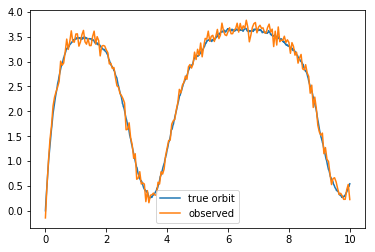

Before assimilation
cost 236.425066716


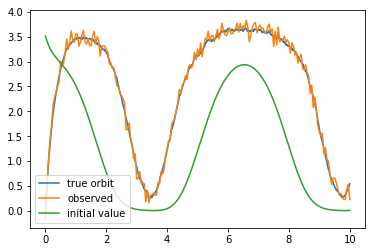

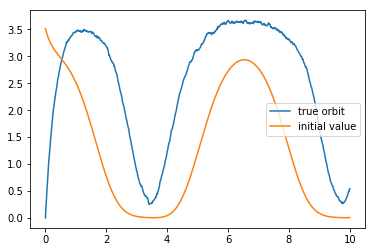

Analytical and numerical gradient comparison
gr_anal [  9.91262338e+00  -7.31931348e+01  -1.31427162e+01   2.27858507e+02
   5.33029362e+01  -2.30236682e+00  -6.92428207e+00  -1.09218916e+01
  -1.24275866e+01  -8.78707494e+00  -3.00334919e+00  -3.28367804e+00
  -8.68842381e+00  -1.12722405e+01  -9.35122143e+00  -6.27362533e+00
  -4.42733839e+00  -4.36579938e+00  -5.98724229e+00  -8.59049589e+00
  -1.19038929e+01  -1.16402327e+01  -6.12026820e+00  -2.16292544e+00
  -2.19072569e-01]
gr_num [  9.91411517e+00  -7.31962158e+01  -1.31420548e+01   2.27876471e+02
   5.32910713e+01  -2.30037503e+00  -6.92229028e+00  -1.09198998e+01
  -1.24255948e+01  -8.78508315e+00  -3.00135740e+00  -3.28168624e+00
  -8.68643202e+00  -1.12702487e+01  -9.34922964e+00  -6.27163353e+00
  -4.42534659e+00  -4.36380759e+00  -5.98525050e+00  -8.58850409e+00
  -1.19019011e+01  -1.16382409e+01  -6.11827669e+00  -2.16095038e+00
  -2.18072569e-01]
relative error [ -1.50471542e-04  -4.20915899e-05   5.03306260e-05  -7.883

true x0 [ 0.]


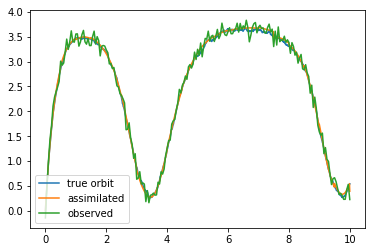

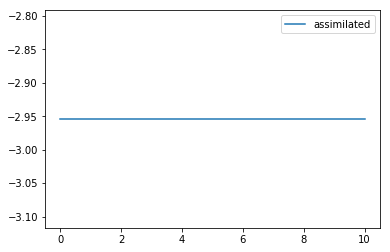

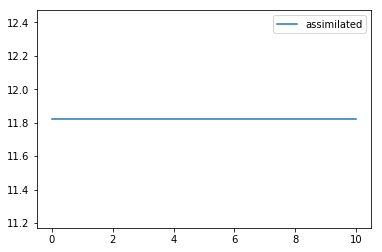

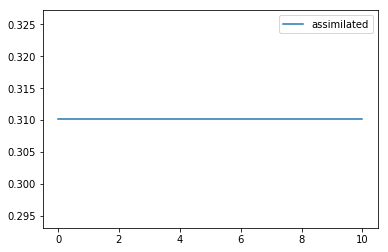

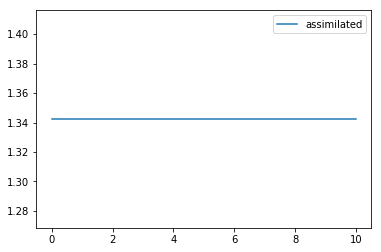

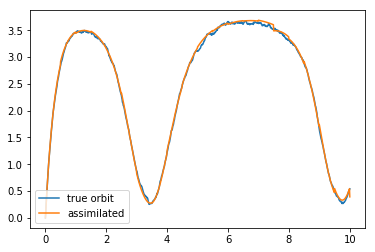

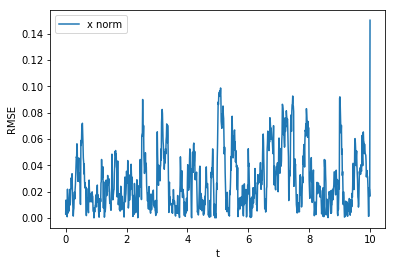

RMSE:  0.0299967594908
hessian [[  3.85957588e+00   2.02179055e+00   1.03136120e+00  -4.32657374e+00
    1.78040717e+00]
 [  2.02179055e+00   1.69895678e+02   4.24724887e+01  -3.59128453e+02
    7.09333337e+01]
 [  1.03136120e+00   4.24724887e+01   1.10369599e+01  -8.84570705e+01
    1.92926686e+01]
 [ -4.32657374e+00  -3.59128453e+02  -8.84570705e+01   1.04117233e+03
   -1.15972048e+02]
 [  1.78040717e+00   7.09333337e+01   1.92926686e+01  -1.15972048e+02
    4.41202808e+01]]
hessian_num [[  3.85957588e+00   2.02235918e+00   1.03136120e+00  -4.32657374e+00
    1.78040717e+00]
 [  2.02353530e+00   1.70062800e+02   4.25003561e+01  -3.59366211e+02
    7.09789543e+01]
 [  1.03136120e+00   4.24760818e+01   1.10369599e+01  -8.84645532e+01
    1.92943006e+01]
 [ -4.32733537e+00  -3.58565682e+02  -8.83197331e+01   1.03791320e+03
   -1.15775318e+02]
 [  1.77906343e+00   7.09075440e+01   1.92856524e+01  -1.15896174e+02
    4.40474995e+01]]
relative error [[  7.23737845e-13  -2.81254106e-04  -5.

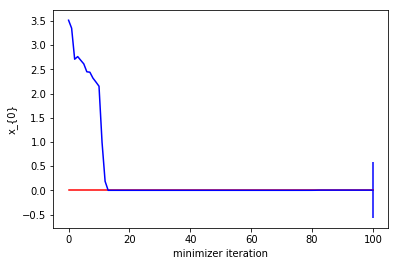

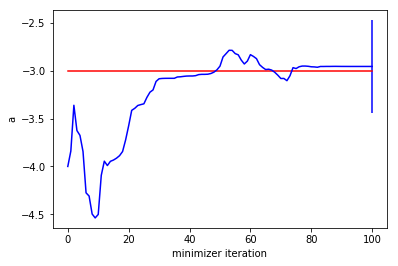

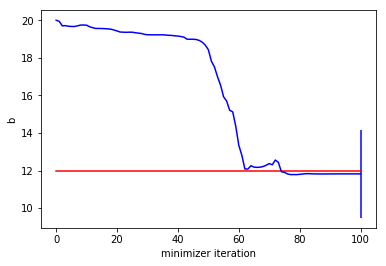

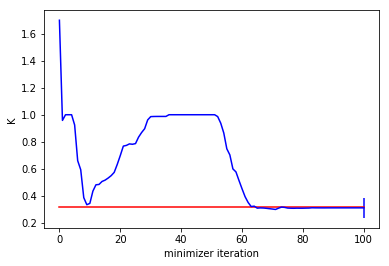

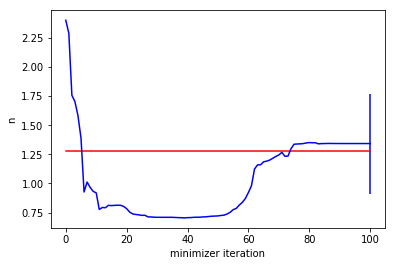

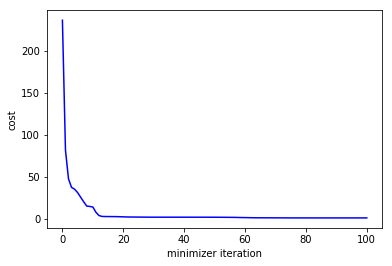

4DVar optimal cost:  1.06657653062
true cost:  1.08687782296


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy.stats
import math

def handler(func, *args):
    return func(*args)

#%%
class Hill:
    def __init__(self, ctrl, dt):
        self.ctrl = ctrl
        self.dt = dt
        self.N = 1
        self.M = 4 # x0=x, x1=a, x2=b, x3=K, x4=n
#        self.m = np.zeros((self.N + self.M, self.N + self.M))
#        self.mm = np.zeros((self.N + self.M, self.N + self.M, self.N + self.M))

    def gradient(self, t, x, x_next):
        u = self.ctrl(t)

        u_n = math.pow(u, x[4])
        K_n = math.pow(x[3], x[4])
        
        x_next[0] = (1. + self.dt * x[1]) * x[0] + self.dt * x[2] * u_n / (K_n + u_n)
        x_next[1] = x[1]
        x_next[2] = x[2]
        x_next[3] = x[3]
        x_next[4] = x[4]
        
        return x_next
        
#    def tl(self, t, x):
#        # validated code
#        u = self.ctrl(t)
#        
#        for i in range(1, self.N + self.M):
#            self.m[i,i] = 1.
#        self.m[0,0] = 1. + self.dt * x[1]
#        self.m[0,1] =  self.dt * x[0]
#        
#        try:
#            K_over_u = x[3]/u
#            l_K_over_u = math.log(K_over_u)
#            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(x[4] * l_K_over_u))
#            self.m[0,2] =  self.dt / (1. + math.pow(K_over_u, x[4]))
#            self.m[0,3] = -self.dt * x[2] * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv
#            self.m[0,4] = -self.dt * x[2] / 2. * l_K_over_u * cosh_n_l_K_over_u_plus_1_inv
#        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
#            self.m[0,2] = 0.
#            self.m[0,3] = 0.
#            self.m[0,4] = 0.
#            
#        return self.m            

#    def gradient_adjoint(self, t, la, x):
#        return self.tl(t, x).transpose() @ la

#    def gradient_adjoint(self, t, la, x):
#        # validated code
#        u = self.ctrl(t)
#        d = np.copy(la)
#        
#        d[0] += self.dt * x[1] * la[0]
#        d[1] += self.dt * x[0] * la[0]
#        try:
#            K_over_u = x[3]/u
#            l_K_over_u = math.log(K_over_u)
#            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(x[4] * l_K_over_u))
#            d[2] += self.dt / (1. + math.pow(K_over_u, x[4])) * la[0]
#            d[3] -= self.dt * x[2] * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * la[0]
#            d[4] -= self.dt * x[2] / 2. * l_K_over_u * cosh_n_l_K_over_u_plus_1_inv * la[0]
#        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
#            pass
#        
#        return d

    def gradient_adjoint(self, t, la, x):
        # validated code
        u = self.ctrl(t)
        d = np.zeros(self.N + self.M)
        
        d[0] = x[1]
        d[1] = x[0]
        
        try:
            K_over_u = x[3]/u
            l_K_over_u = math.log(K_over_u)
            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(x[4] * l_K_over_u))
            d[2] = 1. / (1. + math.pow(K_over_u, x[4]))
            d[3] = - x[2] * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv
            d[4] = - x[2] / 2. * l_K_over_u * cosh_n_l_K_over_u_plus_1_inv
        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError) as e:
#            print('gradient_adjoint exception:', e)
            d[2] = 0
            d[3] = 0
            d[4] = 0
        
        return la + self.dt * la[0] * d

#    def gradient_neighboring(self, t, xi, x):
#        return self.tl(t, x) @ xi

    def gradient_neighboring(self, t, xi, x):
        # validated code
        u = self.ctrl(t)
        d = np.zeros(self.N + self.M)
        
        try:
            K_over_u = x[3]/u
            l_K_over_u = math.log(K_over_u)
            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(x[4] * l_K_over_u))

            d[0] = xi[2] / (1. + math.pow(K_over_u, x[4]))\
                 - xi[3] * x[2] * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv\
                 - xi[4] * x[2] / 2. * l_K_over_u * cosh_n_l_K_over_u_plus_1_inv
        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError) as e:
#            print('gradient_neighboring exception:', e)
            d[0] = 0
        
        d[0] += x[1] * xi[0] + x[0] * xi[1]
        
        return xi + self.dt * d
        
#    def tl_hessian(self, t, x):
#        # validated code
#        u = self.ctrl(t)
#        
#        self.mm[0,0,1] = 1.
#        self.mm[0,1,0] = 1.
#        
#        try:
#            l_K_over_u = math.log(x[3]/u)
#            n_l_K_over_u = x[4] * l_K_over_u                
#            sinh_n_l_K_over_u = math.sinh(n_l_K_over_u)
#            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(n_l_K_over_u))
#
#            for i in range(2,self.N + self.M):
#                for k in range(2,self.N + self.M):
#                    self.mm[0,i,k] = \
#                                   - ((2==i)*(3==k) + (3==i)*(2==k)) * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv\
#                                   - ((2==i)*(4==k) + (4==i)*(2==k)) * l_K_over_u / 2. * cosh_n_l_K_over_u_plus_1_inv\
#                                   +  (3==i)*(3==k)                  * x[2] * x[4] / x[3]**2 / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. + x[4] * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )\
#                                   - ((3==i)*(4==k) + (4==i)*(3==k)) * x[2] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. - x[4] * l_K_over_u * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )\
#                                   +  (4==i)*(4==k)                  * x[2] / 2. * l_K_over_u**2 * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv**2
#        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
#            for i in range(2,self.N + self.M):
#                for k in range(2,self.N + self.M):
#                    self.mm[0,i,k] = 0.
#        self.mm *= self.dt
#        return self.mm
    
#    def gradient_secondadj(self, t, nu, x, la, xi):
#        return self.gradient_adjoint(t, nu, x) + (self.tl_hessian(t, x) @ xi).transpose() @ la

#    def gradient_secondadj(self, t, nu, x, la, xi):
#        # validated code
#        u = self.ctrl(t)
#        
#        d = np.zeros(self.N + self.M)
#        
#        d[0] = xi[1]
#        d[1] = xi[0]
#        
#        try:
#            l_K_over_u = math.log(x[3]/u)
#            n_l_K_over_u = x[4] * l_K_over_u                
#            sinh_n_l_K_over_u = math.sinh(n_l_K_over_u)
#            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(n_l_K_over_u))
#            
#            term2_3 = -x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv
#            term2_4 = -l_K_over_u / 2. * cosh_n_l_K_over_u_plus_1_inv
#            term3_3 = x[2] * x[4] / x[3]**2 / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. + x[4] * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
#            term3_4 = -x[2] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. - x[4] * l_K_over_u * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
#            term4_4 = x[2] / 2. * l_K_over_u**2 * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv**2
#            
#            d[2] = xi[3] * term2_3 + xi[4] * term2_4
#            d[3] = xi[2] * term2_3 + xi[3] * term3_3 + xi[4] * term3_4
#            d[4] = xi[2] * term2_4 + xi[3] * term3_4 + xi[4] * term4_4
#        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
#            pass
#        return self.gradient_adjoint(t, nu, x) + la[0] * self.dt * d

#    def gradient_secondadj(self, t, nu, x, la, xi):
#        # validated code
#        u = self.ctrl(t)
#        
#        d = np.zeros(self.N + self.M)
#        
#        d[0] = x[1] * nu[0] + xi[1] * la[0]
#        d[1] = x[0] * nu[0] + xi[0] * la[0]
#        
#        try:
#            K_over_u = x[3]/u
#            l_K_over_u = math.log(K_over_u)
#            n_l_K_over_u = x[4] * l_K_over_u                
#            sinh_n_l_K_over_u = math.sinh(n_l_K_over_u)
#            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(n_l_K_over_u))
#            
#            term2_3 = -x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv
#            term2_4 = -l_K_over_u / 2. * cosh_n_l_K_over_u_plus_1_inv
#            term3_3 = x[2] * x[4] / x[3]**2 / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. + x[4] * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
#            term3_4 = -x[2] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. - x[4] * l_K_over_u * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
#            term4_4 = x[2] / 2. * l_K_over_u**2 * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv**2
#            
#            d[2] = nu[0] / (1. + math.pow(K_over_u, x[4]))\
#                 + (xi[3] * term2_3 + xi[4] * term2_4) * la[0]
#            d[3] = -x[2] * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * nu[0]\
#                 + (xi[2] * term2_3 + xi[3] * term3_3 + xi[4] * term3_4) * la[0]
#            d[4] = -x[2] / 2. * l_K_over_u * cosh_n_l_K_over_u_plus_1_inv * nu[0]\
#                 + (xi[2] * term2_4 + xi[3] * term3_4 + xi[4] * term4_4) * la[0]
#        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
#            pass
#        return nu + self.dt * d

    def gradient_secondadj(self, t, nu, x, la, xi):
        # validated code
        u = self.ctrl(t)
        
        d = np.zeros(self.N + self.M)
        
        d[0] = x[1] * nu[0] + xi[1] * la[0]
        d[1] = x[0] * nu[0] + xi[0] * la[0]
        
        try:
            K_over_u = x[3]/u
            l_K_over_u = math.log(K_over_u)
            n_l_K_over_u = x[4] * l_K_over_u                
            sinh_n_l_K_over_u = math.sinh(n_l_K_over_u)
            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(n_l_K_over_u))
            
            term2_3 = -x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv
            term2_4 = -l_K_over_u / 2. * cosh_n_l_K_over_u_plus_1_inv
            term3_3 = x[2] * x[4] / x[3]**2 / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. + x[4] * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
            term3_4 = -x[2] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. - x[4] * l_K_over_u * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
            term4_4 = x[2] / 2. * l_K_over_u**2 * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv**2
            
            d[2] = nu[0] / (1. + math.pow(K_over_u, x[4]))\
                 + (xi[3] * term2_3 + xi[4] * term2_4) * la[0]
            d[3] = x[2] * term2_3 * nu[0]\
                 + (xi[2] * term2_3 + xi[3] * term3_3 + xi[4] * term3_4) * la[0]
            d[4] = x[2] * term2_4 * nu[0]\
                 + (xi[2] * term2_4 + xi[3] * term3_4 + xi[4] * term4_4) * la[0]
        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError) as e:
#            print('gradient_secondadj exception', e)
            d[2] = 0
            d[3] = 0
            d[4] = 0
            
        return nu + self.dt * d

def ramp(t):
    return t

def impulse(t):
    return scipy.stats.norm.pdf(t, 0, 0.1)

def rect(t):
    if (t <= 5):
        return 1.
    else:
        return 0.
    
def zero(t):
    return 0.

def sin(t):
    return 1.0 + math.sin(t)

def cos(t):
    return 1.0 + math.cos(t)

#%%
class Adjoint:
    def __init__(self, dx, dla, dxi, dnu, N, M, T, dt, it, sysnoise_it, obs_variance, sysnoise_variance, x, y, la, xi, nu, q):
        self.dx = dx
        self.dla = dla
        self.dxi = dxi
        self.dnu = dnu
        self.N = N
        self.M = M
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.la = la
        self.xi = xi
        self.nu = nu
        self.q = q
        self.it = it
        self.sysnoise_it = sysnoise_it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.sysnoise_steps = int(self.minute_steps/sysnoise_it)
        self.obs_variance = obs_variance
        self.sysnoise_variance = sysnoise_variance
        self.gr = np.zeros((self.sysnoise_steps + 1) * N + M)
        
    def orbit(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                time = float(n) / self.minute_steps * self.T
                handler(self.dx, time, self.x[n], self.x[n+1])
            self.x[self.sysnoise_it*(i+1), :self.N] += self.q[i]
        return self.x
    
    def neighboring(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                time = float(n) / self.minute_steps * self.T
                self.xi[n+1] = handler(self.dxi, time, self.xi[n], self.x[n])
#            self.xi[self.sysnoise_it*(i+1), :self.N] += self.dq[i] # no sysnoise variational to obtain hessian wrt initial state and parameters
        return self.xi
    
    def observed(self, stddev):
        self.orbit()
        self.x[:self.N] += stddev * np.random.randn(self.steps, self.N)
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        self.x[:self.N] += stddev * np.random.randn(self.steps, self.N)
        return tob, self.x
    
    def gradient(self):
        self.la[self.minute_steps, :self.N] = (self.x[self.minute_steps, :self.N] - self.y[self.steps])/self.obs_variance
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                time = float(n) / self.minute_steps * self.T
                self.la[n] = handler(self.dla, time, self.la[n+1], self.x[n]) # x should be current one.
            self.la[self.it*i, :self.N] += (self.x[self.it*i, :self.N] - self.y[i])/self.obs_variance
        return self.la[0]

    def gradient_from_x0(self, x0_q):
        self.x[0] = np.copy(x0_q[:self.N + self.M])
        for i in range(self.sysnoise_steps):
            self.q[i] = x0_q[self.N*(i+1) + self.M: self.N*(i+2) + self.M]
        self.orbit()
        self.la.fill(0.)
        self.gr.fill(0.)
        self.gradient()
        self.gr[:self.N + self.M] = self.la[0]
        for i in range(self.sysnoise_steps):
            self.gr[self.N*(i+1) + self.M: self.N*(i+2) + self.M] = la[self.sysnoise_it*(i+1), :self.N] + self.q[i]/self.sysnoise_variance # Gamma la[self.sysnoise_it*(i+1)] = la[self.sysnoise_it*(i+1),:self.N]
#            self.gr[self.N*(i+1) + self.M: self.N*(i+2) + self.M] = 0
        return self.gr

    def hessian_vector_product(self, xi0):
        self.xi[0] = np.copy(xi0)
        self.neighboring()
        self.nu.fill(0.)
        self.nu[self.minute_steps, :self.N] = self.xi[self.minute_steps, :self.N]/self.obs_variance # fixed
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                time = float(n) / self.minute_steps * self.T
                self.nu[n] = handler(self.dnu, time, self.nu[n+1], self.x[n], self.la[n+1], self.xi[n]) # x and xi should be current one.
            self.nu[self.it*i, :self.N] += self.xi[self.it*i, :self.N]/self.obs_variance
        return self.nu[0]
    
    def cost(self, x0_q):
        self.x[0] = np.copy(x0_q[:self.N + self.M])
        for i in range(self.sysnoise_steps):
            self.q[i] = x0_q[self.N*(i+1) + self.M : self.N*(i+2) + self.M]
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i, :self.N] - self.y[i]) @ (self.x[self.it*i, :self.N] - self.y[i])/self.obs_variance
        for i in range(self.sysnoise_steps):
            cost += self.q[i] @ self.q[i] / self.sysnoise_variance
        return cost/2.0 # fixed
    
    def true_cost(self, tob):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
            cost += (tob[self.it*i] - self.y[i]) @ (tob[self.it*i] - self.y[i])
        return cost/self.obs_variance/2.0 # fixed
    
    def numerical_gradient_from_x0(self, x0_q, h):
        gr = np.zeros(self.N * (self.sysnoise_steps+1) + self.M)
        c1 = self.cost(x0_q)
        for j in range(self.N * (self.sysnoise_steps+1) + self.M):
            xx = np.copy(x0_q)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h        
        return gr
    
    def numerical_hessian_from_x0(self, x0_q, h):
        hess = np.zeros((self.N + self.M, self.N + self.M))
        gr1 = np.copy(self.gradient_from_x0(x0_q))
#        print("gr1", gr1)
        for i in range(self.N + self.M):
            for j in range(self.N + self.M):
                xx = np.copy(x0_q)
                xx[j] += h
                gr2 = np.copy(self.gradient_from_x0(xx))
#                print("gr2", gr2)
#                print("(gr2 - gr1)", (gr2 - gr1))
                hess[j,i] = (gr2[i] - gr1[i])/h
#                print("")
#            print("")
        return hess
    
    def numerical_hessian_from_x0_2(self, x0_q, h):
        hess = np.zeros((self.N + self.M, self.N + self.M))
        gr1 = np.copy(self.numerical_gradient_from_x0(x0_q, h))
        for i in range(self.N + self.M):
            for j in range(self.N + self.M):
                xx = np.copy(x0_q)
                xx[j] += h
                gr2 = np.copy(self.numerical_gradient_from_x0(xx, h))
                hess[j,i] = (gr2[i] - gr1[i])/h
        return hess
    
    def cbf(self, x0):
        global a_trace, b_trace, K_trace, n_trace, cost_trace, trace
        cos = self.cost(x0)
        a_trace.append(x0[self.N])
        b_trace.append(x0[self.N+1])
        K_trace.append(x0[self.N+2])
        n_trace.append(x0[self.N+3])
        cost_trace.append(cos)
        for i in range(self.N):
            trace[i].append(x0[i])

#%%
def compare_orbit(t1, t2, dat1, dat2, lab1, lab2):
    fig = plt.figure()
    plt.plot(t1, dat1, label=lab1)
    plt.plot(t2, dat2, label=lab2)
    plt.legend()
    plt.show()

def compare_orbit3(t1, t2, t3, dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    plt.plot(t1, dat1, label=label1)
    plt.plot(t2, dat2, label=label2)
    plt.plot(t3, dat3, label=label3)
    plt.legend()
    plt.show()
    
#%%
from scipy.optimize import minimize
np.seterr(invalid='raise')

N = 1
M = 4

ctrl = cos
pref = "/Users/konta/bitbucket/androsace/dacamp/hill_discrete_sysnoise/data/"+ ctrl.__name__ +"/1/"

dt = 0.01

T = 10.
print("T", T)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1.

sysnoise_variance = 1.
sysnoise_it = 50

sysnoise_steps = int(minute_steps/sysnoise_it)

lorenz = Hill(ctrl, dt)

tob = np.loadtxt(pref + "true.1.dat", ndmin=2)

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat", ndmin=2)

t = np.arange(0., T, dt)
t_plus_1 = np.arange(0., T+dt, dt)
t_it = np.arange(0., T, dt*it)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

compare_orbit(t_plus_1, t_it_plus_1, tob[0:minute_steps+1,0], obs[0:steps+1,0], "true orbit", "observed")

x_opt_q = np.zeros((sysnoise_steps + 1) * N + M)
#x_opt_q[:N] = np.copy(tob[0]) + 0.001 * np.random.randn(N)
x_opt_q[:N] = np.loadtxt(pref + "assimilation_xzero.2.dat", ndmin=2)
#x_opt_q[:N] = np.copy(obs[0])
x_opt_q[N] = -4.
x_opt_q[N+1] = 20.
x_opt_q[N+2] = 1.7
x_opt_q[N+3] = 2.4

x  = np.zeros((minute_steps+1, N + M))
la = np.zeros((minute_steps+1, N + M))
xi = np.zeros((minute_steps+1, N + M))
nu = np.zeros((minute_steps+1, N + M))
q  = np.zeros((sysnoise_steps ,N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, lorenz.gradient_neighboring, lorenz.gradient_secondadj, N, M, T, dt, it, sysnoise_it, stddev, sysnoise_variance, x, obs, la, xi, nu, q)

print("Before assimilation")
print("cost", scheme.cost(x_opt_q))
compare_orbit3(t_plus_1, t_it_plus_1, t_plus_1, tob[0:minute_steps+1,0], obs[0:steps+1,0], scheme.x[:,0], 'true orbit', 'observed', 'initial value')
compare_orbit(t_plus_1, t_plus_1, tob[0:minute_steps+1,0], scheme.x[:,0], "true orbit", "initial value")

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt_q)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt_q, 0.001)
print ("gr_num", gr_num)
if (not (0 in gr_num)):
    print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
fig = plt.figure()
a_trace = [x_opt_q[N]]
b_trace = [x_opt_q[N+1]]
K_trace = [x_opt_q[N+2]]
n_trace = [x_opt_q[N+3]]
cost_trace = [scheme.cost(x_opt_q)]
trace=[]
for i in range(N):
    trace.append([x_opt_q[i]])

#bnds = tuple([(-8., 24.) for i in range(N * (sysnoise_steps + 1))])
#bnds_list = [(0, None), (None, None), (None, None), (0.1, None), (0, None)]
bnds_list = [(0, None), (None, None), (None, None), (0.1, 1.), (0, None)]
for i in range(sysnoise_steps * N):
    bnds_list.append((None, None))
bnds = tuple(bnds_list)
res = minimize(scheme.cost, x_opt_q, jac=scheme.gradient_from_x0, method='L-BFGS-B', bounds=bnds, callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
#res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
plt.show()
#print (res)
print ("true x0", tob[0])
estimated_x0 = np.copy(res.x)

for j in range(N):
    fig = plt.figure()
    plt.plot(t_plus_1, tob[0:minute_steps+1,j], label='true orbit')
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.plot(t_it_plus_1, obs[0:steps+1,j], label='observed')
    plt.legend()
    plt.show()

for j in range(N,N+M):
    fig = plt.figure()
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.legend()
    plt.show()

compare_orbit(t_plus_1, t_plus_1, tob[0:minute_steps+1,0], scheme.x[:,0], "true orbit", "assimilated")

#%%
fig = plt.figure()
plt.plot(t_plus_1, [np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(len(t_plus_1))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(int(len(t_plus_1)*0.4),int(len(t_plus_1)*0.6))]))


#%%
hessian_T = np.zeros((N + M, N + M))
xi0 = np.zeros(N + M)
for i in range(N + M):
    xi0.fill(0.)
    xi0[i] = 1.
    hessian_T[i] = np.copy(scheme.hessian_vector_product(xi0))

hessian = hessian_T.transpose()
hessian_inv = np.linalg.inv(hessian)
print("hessian", hessian)
#print("hessian_inverse", hessian_inv)
variance = np.diag(hessian_inv)
#print("variance", variance)
std_deviation = np.array([math.sqrt(variance[i]) for i in range(N + M)])

hess_num = scheme.numerical_hessian_from_x0(estimated_x0, 0.001)
print ("hessian_num", hess_num)

#hess_num2 = scheme.numerical_hessian_from_x0_2(estimated_x0, 0.001)
#print ("hessian_num2", hess_num2)


rel_error = (hessian - hess_num)/ hessian
print ("relative error", rel_error)

#rel_error_2 = (hessian - hess_num2)/ hessian
#print ("relative error2", rel_error_2)

abs_error = (hessian - hess_num)
print ("absolute error", abs_error)

#abs_error_2 = (hessian - hess_num2)
#print ("absolute error2", abs_error_2)

hess_num_inv = np.linalg.inv(hess_num)

for j in range(N):
    plt.plot([tob[0,j] for i in range(len(trace[j]))], 'r')
    plt.plot(trace[j], 'b')
    plt.errorbar(len(trace[j])-1, trace[j][-1], yerr=std_deviation[j], fmt='b')
    plt.legend()
    plt.xlabel('minimizer iteration')
    plt.ylabel('x_{' + str(j) + '}')
    plt.show()

true_param = np.array([-3., 12., 0.3132, 1.276])

fig = plt.figure()
plt.plot([true_param[0] for i in range(len(a_trace))], 'r')
plt.plot(a_trace, 'b')
plt.errorbar(len(a_trace)-1, a_trace[-1], yerr=std_deviation[N], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('a')
plt.show()

fig = plt.figure()
plt.plot([true_param[1] for i in range(len(b_trace))], 'r')
plt.plot(b_trace, 'b')
plt.errorbar(len(b_trace)-1, b_trace[-1], yerr=std_deviation[N+1], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('b')
plt.show()

fig = plt.figure()
plt.plot([true_param[2] for i in range(len(K_trace))], 'r')
plt.plot(K_trace, 'b')
plt.errorbar(len(K_trace)-1, K_trace[-1], yerr=std_deviation[N+2], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('K')
plt.show()

fig = plt.figure()
plt.plot([true_param[3] for i in range(len(n_trace))], 'r')
plt.plot(n_trace, 'b')
plt.errorbar(len(n_trace)-1, n_trace[-1], yerr=std_deviation[N+3], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('n')
plt.show()


fig = plt.figure()
plt.plot(cost_trace, 'b')
plt.xlabel('minimizer iteration')
plt.ylabel('cost')
plt.show()

#%%
print('4DVar optimal cost: ', res.fun)
print('true cost: ', scheme.true_cost(tob))

## Hill式システムにおける双子実験2

T 2.0


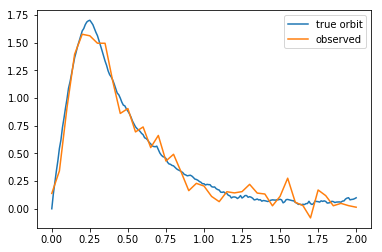

Before assimilation
cost 1.47600538829


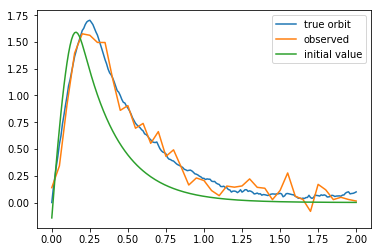

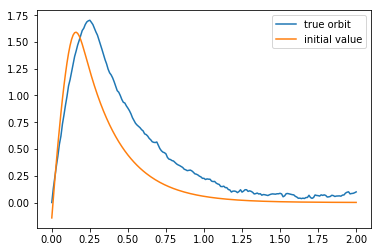

Analytical and numerical gradient comparison
gr_anal [-0.47734702 -0.8982676  -0.09280756  1.06294946  0.11751236 -1.77280928
 -0.56023211 -0.45190019 -0.01304226]
gr_num [-0.47585523 -0.89825463 -0.0927917   1.06348891  0.11746357 -1.77081749
 -0.5582406  -0.44992513 -0.01204226]
relative error [  3.13497014e-03   1.44457598e-05   1.70966502e-04  -5.07247026e-04
   4.15375546e-04   1.12478404e-03   3.56747565e-03   4.38975299e-03
   8.30409146e-02]


true x0 [ 0.]


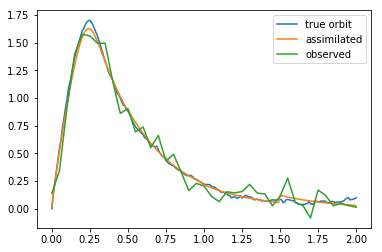

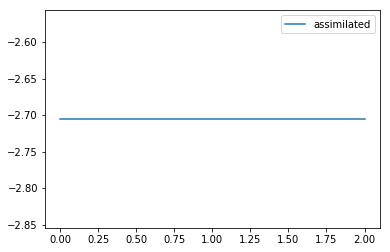

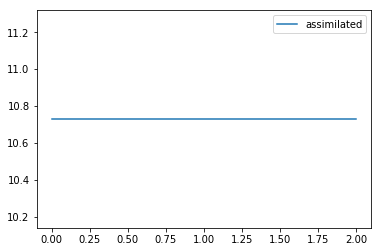

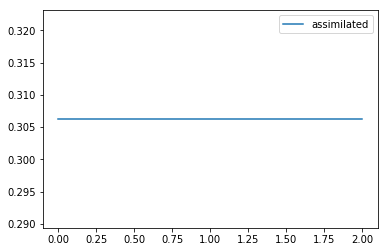

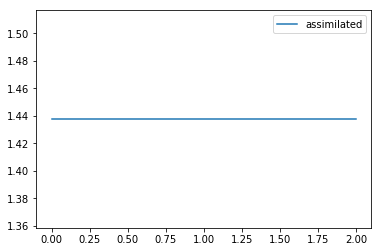

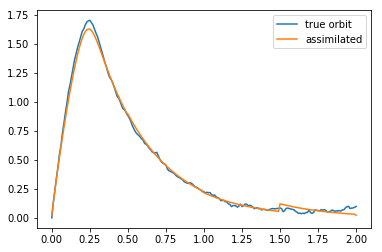

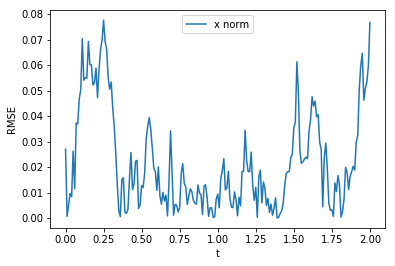

RMSE:  0.00980825116262
hessian [[ 4.16868552  1.2047358   0.60074142 -3.63716343  0.42348434]
 [ 1.2047358   1.45495013  0.36033734 -3.13394125  0.15075255]
 [ 0.60074142  0.36033734  0.14950052 -1.07106268  0.09724717]
 [-3.63716343 -3.13394125 -1.07106268  8.95970717 -0.58095259]
 [ 0.42348434  0.15075255  0.09724717 -0.58095259  0.08997904]]
hessian_num [[ 4.16868552  1.20541452  0.60074142 -3.63716343  0.42348434]
 [ 1.20553991  1.45617184  0.36054053 -3.13558984  0.15084775]
 [ 0.60074142  0.36037041  0.14950052 -1.07116251  0.09725623]
 [-3.63343082 -3.12775145 -1.06900613  8.9254175  -0.58047086]
 [ 0.4231393   0.15066789  0.09718281 -0.58050692  0.08977564]]
relative error [[ -6.49618684e-13  -5.63381158e-04  -1.22177099e-12  -1.61706165e-12
   -8.20310816e-13]
 [ -6.67460728e-04  -8.39688198e-04  -5.63897806e-04  -5.26043176e-04
   -6.31456662e-04]
 [  3.53262026e-12  -9.17867117e-05   4.17928814e-12  -9.32058270e-05
   -9.32057561e-05]
 [  1.02624034e-03   1.97508350e-03   1

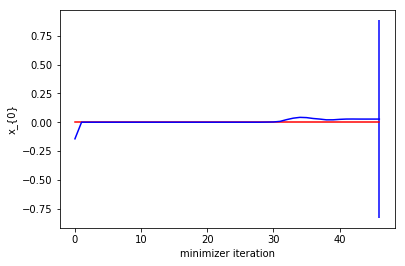

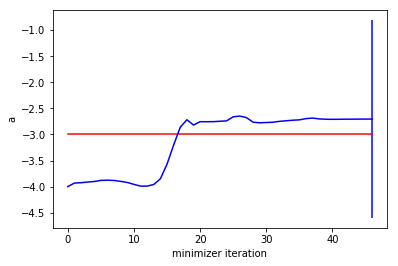

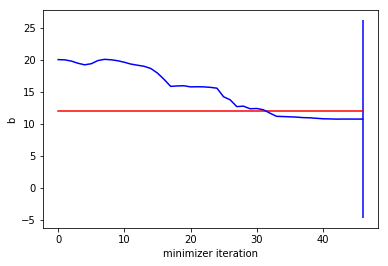

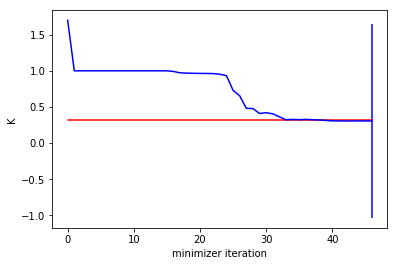

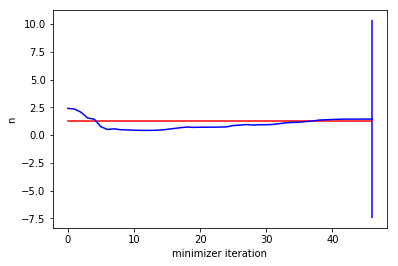

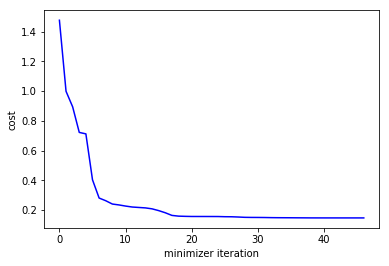

4DVar optimal cost:  0.14664577439
true cost:  0.161187996398


In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy.stats
import math

def handler(func, *args):
    return func(*args)

#%%
class Hill:
    def __init__(self, ctrl, dt):
        self.ctrl = ctrl
        self.dt = dt
        self.N = 1
        self.M = 4 # x0=x, x1=a, x2=b, x3=K, x4=n
#        self.m = np.zeros((self.N + self.M, self.N + self.M))
#        self.mm = np.zeros((self.N + self.M, self.N + self.M, self.N + self.M))

    def gradient(self, t, x, x_next):
        u = self.ctrl(t)

        u_n = math.pow(u, x[4])
        K_n = math.pow(x[3], x[4])
        
        x_next[0] = (1. + self.dt * x[1]) * x[0] + self.dt * x[2] * u_n / (K_n + u_n)
        x_next[1] = x[1]
        x_next[2] = x[2]
        x_next[3] = x[3]
        x_next[4] = x[4]
        
        return x_next
        
#    def tl(self, t, x):
#        # validated code
#        u = self.ctrl(t)
#        
#        for i in range(1, self.N + self.M):
#            self.m[i,i] = 1.
#        self.m[0,0] = 1. + self.dt * x[1]
#        self.m[0,1] =  self.dt * x[0]
#        
#        try:
#            K_over_u = x[3]/u
#            l_K_over_u = math.log(K_over_u)
#            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(x[4] * l_K_over_u))
#            self.m[0,2] =  self.dt / (1. + math.pow(K_over_u, x[4]))
#            self.m[0,3] = -self.dt * x[2] * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv
#            self.m[0,4] = -self.dt * x[2] / 2. * l_K_over_u * cosh_n_l_K_over_u_plus_1_inv
#        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
#            self.m[0,2] = 0.
#            self.m[0,3] = 0.
#            self.m[0,4] = 0.
#            
#        return self.m            

#    def gradient_adjoint(self, t, la, x):
#        return self.tl(t, x).transpose() @ la

#    def gradient_adjoint(self, t, la, x):
#        # validated code
#        u = self.ctrl(t)
#        d = np.copy(la)
#        
#        d[0] += self.dt * x[1] * la[0]
#        d[1] += self.dt * x[0] * la[0]
#        try:
#            K_over_u = x[3]/u
#            l_K_over_u = math.log(K_over_u)
#            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(x[4] * l_K_over_u))
#            d[2] += self.dt / (1. + math.pow(K_over_u, x[4])) * la[0]
#            d[3] -= self.dt * x[2] * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * la[0]
#            d[4] -= self.dt * x[2] / 2. * l_K_over_u * cosh_n_l_K_over_u_plus_1_inv * la[0]
#        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
#            pass
#        
#        return d

    def gradient_adjoint(self, t, la, x):
        # validated code
        u = self.ctrl(t)
        d = np.zeros(self.N + self.M)
        
        d[0] = x[1]
        d[1] = x[0]
        
        try:
            K_over_u = x[3]/u
            l_K_over_u = math.log(K_over_u)
            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(x[4] * l_K_over_u))
            d[2] = 1. / (1. + math.pow(K_over_u, x[4]))
            d[3] = - x[2] * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv
            d[4] = - x[2] / 2. * l_K_over_u * cosh_n_l_K_over_u_plus_1_inv
        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError) as e:
#            print('gradient_adjoint exception:', e)
            d[2] = 0
            d[3] = 0
            d[4] = 0
        
        return la + self.dt * la[0] * d

#    def gradient_neighboring(self, t, xi, x):
#        return self.tl(t, x) @ xi

    def gradient_neighboring(self, t, xi, x):
        # validated code
        u = self.ctrl(t)
        d = np.zeros(self.N + self.M)
        
        try:
            K_over_u = x[3]/u
            l_K_over_u = math.log(K_over_u)
            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(x[4] * l_K_over_u))

            d[0] = xi[2] / (1. + math.pow(K_over_u, x[4]))\
                 - xi[3] * x[2] * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv\
                 - xi[4] * x[2] / 2. * l_K_over_u * cosh_n_l_K_over_u_plus_1_inv
        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError) as e:
#            print('gradient_neighboring exception:', e)
            d[0] = 0
        
        d[0] += x[1] * xi[0] + x[0] * xi[1]
        
        return xi + self.dt * d
        
#    def tl_hessian(self, t, x):
#        # validated code
#        u = self.ctrl(t)
#        
#        self.mm[0,0,1] = 1.
#        self.mm[0,1,0] = 1.
#        
#        try:
#            l_K_over_u = math.log(x[3]/u)
#            n_l_K_over_u = x[4] * l_K_over_u                
#            sinh_n_l_K_over_u = math.sinh(n_l_K_over_u)
#            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(n_l_K_over_u))
#
#            for i in range(2,self.N + self.M):
#                for k in range(2,self.N + self.M):
#                    self.mm[0,i,k] = \
#                                   - ((2==i)*(3==k) + (3==i)*(2==k)) * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv\
#                                   - ((2==i)*(4==k) + (4==i)*(2==k)) * l_K_over_u / 2. * cosh_n_l_K_over_u_plus_1_inv\
#                                   +  (3==i)*(3==k)                  * x[2] * x[4] / x[3]**2 / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. + x[4] * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )\
#                                   - ((3==i)*(4==k) + (4==i)*(3==k)) * x[2] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. - x[4] * l_K_over_u * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )\
#                                   +  (4==i)*(4==k)                  * x[2] / 2. * l_K_over_u**2 * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv**2
#        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
#            for i in range(2,self.N + self.M):
#                for k in range(2,self.N + self.M):
#                    self.mm[0,i,k] = 0.
#        self.mm *= self.dt
#        return self.mm
    
#    def gradient_secondadj(self, t, nu, x, la, xi):
#        return self.gradient_adjoint(t, nu, x) + (self.tl_hessian(t, x) @ xi).transpose() @ la

#    def gradient_secondadj(self, t, nu, x, la, xi):
#        # validated code
#        u = self.ctrl(t)
#        
#        d = np.zeros(self.N + self.M)
#        
#        d[0] = xi[1]
#        d[1] = xi[0]
#        
#        try:
#            l_K_over_u = math.log(x[3]/u)
#            n_l_K_over_u = x[4] * l_K_over_u                
#            sinh_n_l_K_over_u = math.sinh(n_l_K_over_u)
#            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(n_l_K_over_u))
#            
#            term2_3 = -x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv
#            term2_4 = -l_K_over_u / 2. * cosh_n_l_K_over_u_plus_1_inv
#            term3_3 = x[2] * x[4] / x[3]**2 / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. + x[4] * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
#            term3_4 = -x[2] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. - x[4] * l_K_over_u * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
#            term4_4 = x[2] / 2. * l_K_over_u**2 * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv**2
#            
#            d[2] = xi[3] * term2_3 + xi[4] * term2_4
#            d[3] = xi[2] * term2_3 + xi[3] * term3_3 + xi[4] * term3_4
#            d[4] = xi[2] * term2_4 + xi[3] * term3_4 + xi[4] * term4_4
#        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
#            pass
#        return self.gradient_adjoint(t, nu, x) + la[0] * self.dt * d

#    def gradient_secondadj(self, t, nu, x, la, xi):
#        # validated code
#        u = self.ctrl(t)
#        
#        d = np.zeros(self.N + self.M)
#        
#        d[0] = x[1] * nu[0] + xi[1] * la[0]
#        d[1] = x[0] * nu[0] + xi[0] * la[0]
#        
#        try:
#            K_over_u = x[3]/u
#            l_K_over_u = math.log(K_over_u)
#            n_l_K_over_u = x[4] * l_K_over_u                
#            sinh_n_l_K_over_u = math.sinh(n_l_K_over_u)
#            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(n_l_K_over_u))
#            
#            term2_3 = -x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv
#            term2_4 = -l_K_over_u / 2. * cosh_n_l_K_over_u_plus_1_inv
#            term3_3 = x[2] * x[4] / x[3]**2 / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. + x[4] * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
#            term3_4 = -x[2] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. - x[4] * l_K_over_u * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
#            term4_4 = x[2] / 2. * l_K_over_u**2 * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv**2
#            
#            d[2] = nu[0] / (1. + math.pow(K_over_u, x[4]))\
#                 + (xi[3] * term2_3 + xi[4] * term2_4) * la[0]
#            d[3] = -x[2] * x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * nu[0]\
#                 + (xi[2] * term2_3 + xi[3] * term3_3 + xi[4] * term3_4) * la[0]
#            d[4] = -x[2] / 2. * l_K_over_u * cosh_n_l_K_over_u_plus_1_inv * nu[0]\
#                 + (xi[2] * term2_4 + xi[3] * term3_4 + xi[4] * term4_4) * la[0]
#        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
#            pass
#        return nu + self.dt * d

    def gradient_secondadj(self, t, nu, x, la, xi):
        # validated code
        u = self.ctrl(t)
        
        d = np.zeros(self.N + self.M)
        
        d[0] = x[1] * nu[0] + xi[1] * la[0]
        d[1] = x[0] * nu[0] + xi[0] * la[0]
        
        try:
            K_over_u = x[3]/u
            l_K_over_u = math.log(K_over_u)
            n_l_K_over_u = x[4] * l_K_over_u                
            sinh_n_l_K_over_u = math.sinh(n_l_K_over_u)
            cosh_n_l_K_over_u_plus_1_inv = 1. / (1. + math.cosh(n_l_K_over_u))
            
            term2_3 = -x[4] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv
            term2_4 = -l_K_over_u / 2. * cosh_n_l_K_over_u_plus_1_inv
            term3_3 = x[2] * x[4] / x[3]**2 / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. + x[4] * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
            term3_4 = -x[2] / x[3] / 2. * cosh_n_l_K_over_u_plus_1_inv * ( 1. - x[4] * l_K_over_u * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv )
            term4_4 = x[2] / 2. * l_K_over_u**2 * sinh_n_l_K_over_u * cosh_n_l_K_over_u_plus_1_inv**2
            
            d[2] = nu[0] / (1. + math.pow(K_over_u, x[4]))\
                 + (xi[3] * term2_3 + xi[4] * term2_4) * la[0]
            d[3] = x[2] * term2_3 * nu[0]\
                 + (xi[2] * term2_3 + xi[3] * term3_3 + xi[4] * term3_4) * la[0]
            d[4] = x[2] * term2_4 * nu[0]\
                 + (xi[2] * term2_4 + xi[3] * term3_4 + xi[4] * term4_4) * la[0]
        except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError) as e:
#            print('gradient_secondadj exception', e)
            d[2] = 0
            d[3] = 0
            d[4] = 0
            
        return nu + self.dt * d

def ramp(t):
    return t

def impulse(t):
    return scipy.stats.norm.pdf(t, 0, 0.1)

def rect(t):
    if (t <= 5):
        return 1.
    else:
        return 0.
    
def zero(t):
    return 0.

def sin(t):
    return 1.0 + math.sin(t)

def cos(t):
    return 1.0 + math.cos(t)

#%%
class Adjoint:
    def __init__(self, dx, dla, dxi, dnu, N, M, T, dt, it, sysnoise_it, obs_variance, sysnoise_variance, x, y, la, xi, nu, q):
        self.dx = dx
        self.dla = dla
        self.dxi = dxi
        self.dnu = dnu
        self.N = N
        self.M = M
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.la = la
        self.xi = xi
        self.nu = nu
        self.q = q
        self.it = it
        self.sysnoise_it = sysnoise_it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.sysnoise_steps = int(self.minute_steps/sysnoise_it)
        self.obs_variance = obs_variance
        self.sysnoise_variance = sysnoise_variance
        self.gr = np.zeros((self.sysnoise_steps + 1) * N + M)
        
    def orbit(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                time = float(n) / self.minute_steps * self.T
                handler(self.dx, time, self.x[n], self.x[n+1])
            self.x[self.sysnoise_it*(i+1), :self.N] += self.q[i]
        return self.x
    
    def neighboring(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                time = float(n) / self.minute_steps * self.T
                self.xi[n+1] = handler(self.dxi, time, self.xi[n], self.x[n])
#            self.xi[self.sysnoise_it*(i+1), :self.N] += self.dq[i] # no sysnoise variational to obtain hessian wrt initial state and parameters
        return self.xi
    
    def observed(self, stddev):
        self.orbit()
        self.x[:self.N] += stddev * np.random.randn(self.steps, self.N)
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        self.x[:self.N] += stddev * np.random.randn(self.steps, self.N)
        return tob, self.x
    
    def gradient(self):
        self.la[self.minute_steps, :self.N] = (self.x[self.minute_steps, :self.N] - self.y[self.steps])/self.obs_variance
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                time = float(n) / self.minute_steps * self.T
                self.la[n] = handler(self.dla, time, self.la[n+1], self.x[n]) # x should be current one.
            self.la[self.it*i, :self.N] += (self.x[self.it*i, :self.N] - self.y[i])/self.obs_variance
        return self.la[0]

    def gradient_from_x0(self, x0_q):
        self.x[0] = np.copy(x0_q[:self.N + self.M])
        for i in range(self.sysnoise_steps):
            self.q[i] = x0_q[self.N*(i+1) + self.M: self.N*(i+2) + self.M]
        self.orbit()
        self.la.fill(0.)
        self.gr.fill(0.)
        self.gradient()
        self.gr[:self.N + self.M] = self.la[0]
        for i in range(self.sysnoise_steps):
            self.gr[self.N*(i+1) + self.M: self.N*(i+2) + self.M] = la[self.sysnoise_it*(i+1), :self.N] + self.q[i]/self.sysnoise_variance # Gamma la[self.sysnoise_it*(i+1)] = la[self.sysnoise_it*(i+1),:self.N]
#            self.gr[self.N*(i+1) + self.M: self.N*(i+2) + self.M] = 0
        return self.gr

    def hessian_vector_product(self, xi0):
        self.xi[0] = np.copy(xi0)
        self.neighboring()
        self.nu.fill(0.)
        self.nu[self.minute_steps, :self.N] = self.xi[self.minute_steps, :self.N]/self.obs_variance # fixed
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                time = float(n) / self.minute_steps * self.T
                self.nu[n] = handler(self.dnu, time, self.nu[n+1], self.x[n], self.la[n+1], self.xi[n]) # x and xi should be current one.
            self.nu[self.it*i, :self.N] += self.xi[self.it*i, :self.N]/self.obs_variance
        return self.nu[0]
    
    def cost(self, x0_q):
        self.x[0] = np.copy(x0_q[:self.N + self.M])
        for i in range(self.sysnoise_steps):
            self.q[i] = x0_q[self.N*(i+1) + self.M : self.N*(i+2) + self.M]
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i, :self.N] - self.y[i]) @ (self.x[self.it*i, :self.N] - self.y[i])/self.obs_variance
        for i in range(self.sysnoise_steps):
            cost += self.q[i] @ self.q[i] / self.sysnoise_variance
        return cost/2.0 # fixed
    
    def true_cost(self, tob):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
            cost += (tob[self.it*i] - self.y[i]) @ (tob[self.it*i] - self.y[i])
        return cost/self.obs_variance/2.0 # fixed
    
    def numerical_gradient_from_x0(self, x0_q, h):
        gr = np.zeros(self.N * (self.sysnoise_steps+1) + self.M)
        c1 = self.cost(x0_q)
        for j in range(self.N * (self.sysnoise_steps+1) + self.M):
            xx = np.copy(x0_q)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h        
        return gr
    
    def numerical_hessian_from_x0(self, x0_q, h):
        hess = np.zeros((self.N + self.M, self.N + self.M))
        gr1 = np.copy(self.gradient_from_x0(x0_q))
#        print("gr1", gr1)
        for i in range(self.N + self.M):
            for j in range(self.N + self.M):
                xx = np.copy(x0_q)
                xx[j] += h
                gr2 = np.copy(self.gradient_from_x0(xx))
#                print("gr2", gr2)
#                print("(gr2 - gr1)", (gr2 - gr1))
                hess[j,i] = (gr2[i] - gr1[i])/h
#                print("")
#            print("")
        return hess
    
    def numerical_hessian_from_x0_2(self, x0_q, h):
        hess = np.zeros((self.N + self.M, self.N + self.M))
        gr1 = np.copy(self.numerical_gradient_from_x0(x0_q, h))
        for i in range(self.N + self.M):
            for j in range(self.N + self.M):
                xx = np.copy(x0_q)
                xx[j] += h
                gr2 = np.copy(self.numerical_gradient_from_x0(xx, h))
                hess[j,i] = (gr2[i] - gr1[i])/h
        return hess
    
    def cbf(self, x0):
        global a_trace, b_trace, K_trace, n_trace, cost_trace, trace
        cos = self.cost(x0)
        a_trace.append(x0[self.N])
        b_trace.append(x0[self.N+1])
        K_trace.append(x0[self.N+2])
        n_trace.append(x0[self.N+3])
        cost_trace.append(cos)
        for i in range(self.N):
            trace[i].append(x0[i])

#%%
def compare_orbit(t1, t2, dat1, dat2, lab1, lab2):
    fig = plt.figure()
    plt.plot(t1, dat1, label=lab1)
    plt.plot(t2, dat2, label=lab2)
    plt.legend()
    plt.show()

def compare_orbit3(t1, t2, t3, dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    plt.plot(t1, dat1, label=label1)
    plt.plot(t2, dat2, label=label2)
    plt.plot(t3, dat3, label=label3)
    plt.legend()
    plt.show()
    
#%%
from scipy.optimize import minimize
np.seterr(invalid='raise')

N = 1
M = 4

ctrl = impulse
pref = "/Users/konta/bitbucket/androsace/dacamp/hill_discrete_sysnoise/data/"+ ctrl.__name__ +"/1/"

dt = 0.01

T = 2.
print("T", T)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1.

sysnoise_variance = 1.
sysnoise_it = 50

sysnoise_steps = int(minute_steps/sysnoise_it)

lorenz = Hill(ctrl, dt)

tob = np.loadtxt(pref + "true.1.dat", ndmin=2)

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat", ndmin=2)

t = np.arange(0., T, dt)
t_plus_1 = np.arange(0., T+dt, dt)
t_it = np.arange(0., T, dt*it)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

compare_orbit(t_plus_1, t_it_plus_1, tob[0:minute_steps+1,0], obs[0:steps+1,0], "true orbit", "observed")

x_opt_q = np.zeros((sysnoise_steps + 1) * N + M)
#x_opt_q[:N] = np.copy(tob[0]) + 0.001 * np.random.randn(N)
x_opt_q[:N] = np.loadtxt(pref + "assimilation_xzero.2.dat", ndmin=2)
#x_opt_q[:N] = np.copy(obs[0])
x_opt_q[N] = -4.
x_opt_q[N+1] = 20.
x_opt_q[N+2] = 1.7
x_opt_q[N+3] = 2.4

x  = np.zeros((minute_steps+1, N + M))
la = np.zeros((minute_steps+1, N + M))
xi = np.zeros((minute_steps+1, N + M))
nu = np.zeros((minute_steps+1, N + M))
q  = np.zeros((sysnoise_steps ,N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, lorenz.gradient_neighboring, lorenz.gradient_secondadj, N, M, T, dt, it, sysnoise_it, stddev, sysnoise_variance, x, obs, la, xi, nu, q)

print("Before assimilation")
print("cost", scheme.cost(x_opt_q))
compare_orbit3(t_plus_1, t_it_plus_1, t_plus_1, tob[0:minute_steps+1,0], obs[0:steps+1,0], scheme.x[:,0], 'true orbit', 'observed', 'initial value')
compare_orbit(t_plus_1, t_plus_1, tob[0:minute_steps+1,0], scheme.x[:,0], "true orbit", "initial value")

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt_q)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt_q, 0.001)
print ("gr_num", gr_num)
if (not (0 in gr_num)):
    print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
fig = plt.figure()
a_trace = [x_opt_q[N]]
b_trace = [x_opt_q[N+1]]
K_trace = [x_opt_q[N+2]]
n_trace = [x_opt_q[N+3]]
cost_trace = [scheme.cost(x_opt_q)]
trace=[]
for i in range(N):
    trace.append([x_opt_q[i]])

#bnds = tuple([(-8., 24.) for i in range(N * (sysnoise_steps + 1))])
#bnds_list = [(0, None), (None, None), (None, None), (0.1, None), (0, None)]
bnds_list = [(0, None), (None, None), (None, None), (0.1, 1.), (0, None)]
for i in range(sysnoise_steps * N):
    bnds_list.append((None, None))
bnds = tuple(bnds_list)
res = minimize(scheme.cost, x_opt_q, jac=scheme.gradient_from_x0, method='L-BFGS-B', bounds=bnds, callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
#res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
plt.show()
#print (res)
print ("true x0", tob[0])
estimated_x0 = np.copy(res.x)

for j in range(N):
    fig = plt.figure()
    plt.plot(t_plus_1, tob[0:minute_steps+1,j], label='true orbit')
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.plot(t_it_plus_1, obs[0:steps+1,j], label='observed')
    plt.legend()
    plt.show()

for j in range(N,N+M):
    fig = plt.figure()
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.legend()
    plt.show()

compare_orbit(t_plus_1, t_plus_1, tob[0:minute_steps+1,0], scheme.x[:,0], "true orbit", "assimilated")

#%%
fig = plt.figure()
plt.plot(t_plus_1, [np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(len(t_plus_1))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(int(len(t_plus_1)*0.4),int(len(t_plus_1)*0.6))]))


#%%
hessian_T = np.zeros((N + M, N + M))
xi0 = np.zeros(N + M)
for i in range(N + M):
    xi0.fill(0.)
    xi0[i] = 1.
    hessian_T[i] = np.copy(scheme.hessian_vector_product(xi0))

hessian = hessian_T.transpose()
hessian_inv = np.linalg.inv(hessian)
print("hessian", hessian)
#print("hessian_inverse", hessian_inv)
variance = np.diag(hessian_inv)
#print("variance", variance)
std_deviation = np.array([math.sqrt(variance[i]) for i in range(N + M)])

hess_num = scheme.numerical_hessian_from_x0(estimated_x0, 0.001)
print ("hessian_num", hess_num)

#hess_num2 = scheme.numerical_hessian_from_x0_2(estimated_x0, 0.001)
#print ("hessian_num2", hess_num2)


rel_error = (hessian - hess_num)/ hessian
print ("relative error", rel_error)

#rel_error_2 = (hessian - hess_num2)/ hessian
#print ("relative error2", rel_error_2)

abs_error = (hessian - hess_num)
print ("absolute error", abs_error)

#abs_error_2 = (hessian - hess_num2)
#print ("absolute error2", abs_error_2)

hess_num_inv = np.linalg.inv(hess_num)

for j in range(N):
    plt.plot([tob[0,j] for i in range(len(trace[j]))], 'r')
    plt.plot(trace[j], 'b')
    plt.errorbar(len(trace[j])-1, trace[j][-1], yerr=std_deviation[j], fmt='b')
    plt.legend()
    plt.xlabel('minimizer iteration')
    plt.ylabel('x_{' + str(j) + '}')
    plt.show()

true_param = np.array([-3., 12., 0.3132, 1.276])

fig = plt.figure()
plt.plot([true_param[0] for i in range(len(a_trace))], 'r')
plt.plot(a_trace, 'b')
plt.errorbar(len(a_trace)-1, a_trace[-1], yerr=std_deviation[N], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('a')
plt.show()

fig = plt.figure()
plt.plot([true_param[1] for i in range(len(b_trace))], 'r')
plt.plot(b_trace, 'b')
plt.errorbar(len(b_trace)-1, b_trace[-1], yerr=std_deviation[N+1], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('b')
plt.show()

fig = plt.figure()
plt.plot([true_param[2] for i in range(len(K_trace))], 'r')
plt.plot(K_trace, 'b')
plt.errorbar(len(K_trace)-1, K_trace[-1], yerr=std_deviation[N+2], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('K')
plt.show()

fig = plt.figure()
plt.plot([true_param[3] for i in range(len(n_trace))], 'r')
plt.plot(n_trace, 'b')
plt.errorbar(len(n_trace)-1, n_trace[-1], yerr=std_deviation[N+3], fmt='b')
plt.legend()
plt.xlabel('minimizer iteration')
plt.ylabel('n')
plt.show()


fig = plt.figure()
plt.plot(cost_trace, 'b')
plt.xlabel('minimizer iteration')
plt.ylabel('cost')
plt.show()

#%%
print('4DVar optimal cost: ', res.fun)
print('true cost: ', scheme.true_cost(tob))

# 来週の目標
- 黒田研実データへの適用
- システムノイズ(なし/あり)固定区間スムーザーの実装